# Human Bone Fracture Detection

We will detect the type of bone breaks in this project. The plans we will follow is
- ~Make a python virtual environment~
- ~Clean and prepare Data~
- [TODO]Create transfer learning model
- Train and get a decent accuracy using just modifications to head
- Unfreezing and running the model
- Test set accuracy and visualization

In [4]:
!pip install numpy
!pip install pandas
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu130
!pip install matplotlib
!pip install timm
!pip install scikit-learn
!pip install -U scikit-image

Looking in indexes: https://download.pytorch.org/whl/cu130
   ---------------------------------------- 0.0/1.9 GB ? eta -:--:--
   ---------------------------------------- 0.0/1.9 GB 53.9 MB/s eta 0:00:35
   ---------------------------------------- 0.0/1.9 GB 46.4 MB/s eta 0:00:40
    --------------------------------------- 0.0/1.9 GB 54.3 MB/s eta 0:00:34
   - -------------------------------------- 0.1/1.9 GB 64.2 MB/s eta 0:00:29
   - -------------------------------------- 0.1/1.9 GB 70.3 MB/s eta 0:00:26
   - -------------------------------------- 0.1/1.9 GB 66.9 MB/s eta 0:00:27
   -- ------------------------------------- 0.1/1.9 GB 69.8 MB/s eta 0:00:26
   -- ------------------------------------- 0.1/1.9 GB 73.1 MB/s eta 0:00:24
   -- ------------------------------------- 0.1/1.9 GB 71.8 MB/s eta 0:00:25
   --- ------------------------------------ 0.1/1.9 GB 68.8 MB/s eta 0:00:25
   --- ------------------------------------ 0.2/1.9 GB 68.5 MB/s eta 0:00:25
   --- ------------------

### Importing dependencies and database

In [1]:
# imorting reqd libs
from pathlib import Path
import pandas as pd
import torch
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# importing transformers and stuff for learning
import timm
import torch.nn as nn
import torch.optim as optim
import os
import shutil
from sklearn.model_selection import train_test_split

from torch.utils.data import WeightedRandomSampler


d:\Chalmers\Study_Period_5\SSY340_Deep_Machine_Learning\bone_fracture\bone_fracture_detection\bfd\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# imoprting dataset


# Creating paths for imports
data_path = Path.cwd()
folder_path = data_path / "bone.v1i.multiclass"

train_path = folder_path / "train"
val_path = folder_path / "valid"
test_path = folder_path / "test"

train_csv_path = train_path / '_classes.csv'
val_csv_path = val_path / '_classes.csv'
test_csv_path = test_path / '_classes.csv'


df_name = 'filename'

In [3]:
# rename training

train_df = pd.read_csv(train_csv_path)
train_df.columns = train_df.columns.str.strip()

prefix = "f1_"
extension = ".jpg"

file_list = sorted(os.listdir(train_path))
new_names = []

for i, old_name in enumerate(file_list, start=1):
    if old_name.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
        new_name = f"{prefix}{i:04d}{extension}"
        old_path = os.path.join(train_path, old_name)
        new_path = os.path.join(train_path, new_name)
        os.rename(old_path, new_path)
        new_names.append((old_name, new_name))

rename_dict = dict(new_names)
train_df[df_name] = train_df[df_name].map(rename_dict).fillna(train_df[df_name])

train_df.to_csv(train_csv_path, index=False)

train_df.head()

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'd:\\Chalmers\\Study_Period_5\\SSY340_Deep_Machine_Learning\\bone_fracture\\bone_fracture_detection\\bone.v1i.multiclass\\train\\f1_0001.jpg' -> 'd:\\Chalmers\\Study_Period_5\\SSY340_Deep_Machine_Learning\\bone_fracture\\bone_fracture_detection\\bone.v1i.multiclass\\train\\f1_0002.jpg'

In [9]:
# rename val

val_df = pd.read_csv(val_csv_path)
val_df.columns = val_df.columns.str.strip()

prefix = "f2_"
extension = ".jpg"

file_list = sorted(os.listdir(val_path))
new_names = []

for i, old_name in enumerate(file_list, start=1):
    if old_name.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
        new_name = f"{prefix}{i:04d}{extension}"
        old_path = os.path.join(val_path, old_name)
        new_path = os.path.join(val_path, new_name)
        os.rename(old_path, new_path)
        new_names.append((old_name, new_name))

rename_dict = dict(new_names)
val_df[df_name] = val_df[df_name].map(rename_dict).fillna(val_df[df_name])

val_df.to_csv(val_csv_path, index=False)

val_df.head()

filename  Avulsion  Comminuted  Compression-Crush  Dislocation  \
0  f2_0234.jpg         0           0                  0            0   
1  f2_0073.jpg         0           0                  0            0   
2  f2_0295.jpg         0           0                  0            0   
3  f2_0241.jpg         0           0                  0            0   
4  f2_0205.jpg         0           0                  0            0   

   Fracture  Greenstick  Hairline  Impacted  Intra-articular  Longitudinal  \
0         1           0         0         0                0             0   
1         0           0         0         0                0             0   
2         0           0         0         0                0             0   
3         1           0         0         0                0             0   
4         0           0         0         0                0             0   

   Oblique  Pathological  Spiral  fracture  
0        0             0       1         0  
1        0             1       0         1  
2        1             0       0         1  
3        0             0       1         0  
4        1             0       0         1

In [10]:
# rename test

test_df = pd.read_csv(test_csv_path)
test_df.columns = test_df.columns.str.strip()

prefix = "f3_"
extension = ".jpg"

file_list = sorted(os.listdir(test_path))
new_names = []

for i, old_name in enumerate(file_list, start=1):
    if old_name.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
        new_name = f"{prefix}{i:04d}{extension}"
        old_path = os.path.join(test_path, old_name)
        new_path = os.path.join(test_path, new_name)
        os.rename(old_path, new_path)
        new_names.append((old_name, new_name))

rename_dict = dict(new_names)
test_df[df_name] = test_df[df_name].map(rename_dict).fillna(test_df[df_name])

test_df.to_csv(test_csv_path, index=False)

test_df.head()

filename  Avulsion  Comminuted  Compression-Crush  Dislocation  \
0  f3_0123.jpg         0           0                  0            0   
1  f3_0122.jpg         0           0                  0            0   
2  f3_0148.jpg         0           0                  0            0   
3  f3_0007.jpg         0           0                  0            0   
4  f3_0135.jpg         0           0                  0            0   

   Fracture  Greenstick  Hairline  Impacted  Intra-articular  Longitudinal  \
0         0           0         0         0                1             0   
1         0           0         0         0                1             0   
2         0           0         0         0                0             1   
3         0           0         0         0                0             0   
4         0           0         0         0                1             0   

   Oblique  Pathological  Spiral  fracture  
0        0             0       0         1  
1        0             0       0         1  
2        0             0       0         1  
3        1             0       0         1  
4        0             0       0         1

In [7]:
combined_path = folder_path / 'all'
# os.makedirs(combined_path, exist_ok=True)

# copy into one folder
# for file_name in os.listdir(val_path):
#     if file_name.lower().endswith(('.jpg', '.png', '.bmp')):
#         src_path = os.path.join(val_path, file_name)
#         print
#         dst_path = os.path.join(combined_path, file_name)
#         try:
#             shutil.copy2(src_path, dst_path)  # copy2 preserves metadata
#             # count += 1
#         except Exception as e:
#             print(f"Could not copy {file_name}: {e}")


# combine all datasets into one
# combined_df = pd.concat([train_df, val_df, test_df])
# combined_df = combined_df.drop(columns=['Fracture', 'fracture'])

combined_csv_path = combined_path / '_classes.csv'

# combined_df.to_csv(combined_csv_path, index=False)

combined_df = pd.read_csv(combined_csv_path)

combined_df.head()

filename  Avulsion  Comminuted  Compression-Crush  Dislocation  \
0  f1_2337.jpg         1           0                  0            0   
1  f1_1893.jpg         1           0                  0            0   
2  f1_2003.jpg         0           1                  0            0   
3  f1_1846.jpg         0           0                  0            0   
4  f1_0742.jpg         1           0                  0            0   

   Greenstick  Hairline  Impacted  Intra-articular  Longitudinal  Oblique  \
0           0         0         0                0             0        0   
1           0         0         0                0             0        0   
2           0         0         0                0             0        0   
3           0         0         1                0             0        0   
4           0         0         0                0             0        0   

   Pathological  Spiral  
0             0       0  
1             0       0  
2             0       0  
3             0       0  
4             0       0

In [9]:
class_columns = [col for col in combined_df.columns if col != 'filename']
print(class_columns)

combined_df['class'] = combined_df[class_columns].idxmax(axis=1)

print(combined_df['class'].value_counts())



['Avulsion', 'Comminuted', 'Compression-Crush', 'Dislocation', 'Greenstick', 'Hairline', 'Impacted', 'Intra-articular', 'Longitudinal', 'Oblique', 'Pathological', 'Spiral']
class
Comminuted           637
Dislocation          471
Compression-Crush    441
Avulsion             407
Hairline             389
Greenstick           387
Impacted             327
Intra-articular      136
Spiral               135
Pathological         126
Oblique               94
Longitudinal          93
Name: count, dtype: int64


In [10]:
train_ratio, val_ratio, test_ratio = 0.8, 0.1, 0.1

train_df, temp_df = train_test_split(
    combined_df,
    test_size=(1 - train_ratio),
    stratify=combined_df['class'],
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=(test_ratio / (test_ratio + val_ratio)),
    stratify=temp_df['class'],
    random_state=42
)

# train_df, temp_df = train_test_split(
#     combined_df, test_size=0.20, stratify=combined_df['class'], random_state=42
# )
# val_df, test_df = train_test_split(
#     temp_df, test_size=0.50, stratify=temp_df['class'], random_state=42
# )

# print(train_df['class'].value_counts())
print(val_df['class'].value_counts())
print(test_df['class'].value_counts())

class
Comminuted           64
Dislocation          47
Compression-Crush    44
Avulsion             41
Hairline             39
Greenstick           38
Impacted             32
Pathological         13
Intra-articular      13
Spiral               13
Longitudinal         10
Oblique              10
Name: count, dtype: int64
class
Comminuted           64
Dislocation          47
Compression-Crush    44
Avulsion             41
Greenstick           39
Hairline             39
Impacted             33
Spiral               14
Intra-articular      14
Pathological         12
Oblique               9
Longitudinal          9
Name: count, dtype: int64


In [20]:
# ---- Modified Dataset Class ----
class BoneDataset(Dataset):
    def __init__(self, df, folder_path, transform=None):
        """
        Args:
            df (pd.DataFrame): DataFrame containing 'filename' and 'class' columns.
            folder_path (str or Path): Path to image directory.
            transform (torchvision.transforms): Transformations to apply.
        """
        self.df = df.reset_index(drop=True)
        self.folder_path = Path(folder_path)
        self.transform = transform

        # Get class mappings (string → int)
        self.classes = sorted(self.df['class'].unique())
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = self.folder_path / row['filename']

        # Load image
        image = Image.open(img_path).convert("L")

        # Convert class name → integer label
        # label = self.class_to_idx[row['class']]
        # label = torch.tensor(label, dtype=torch.long)

        # label = self.df.iloc[idx, 1]      # class label
        label_name = self.df.iloc[idx]['class']
        label_idx = self.class_to_idx[label_name]
        label = torch.tensor(label_idx, dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, label


# ---- Define Transforms ----
transform = T.Compose([
    T.Resize((224, 224)),
    T.Grayscale(num_output_channels=3),
    T.ToTensor(),
    T.Normalize(mean=[0.5], std=[0.5]),
])

# ---- Datasets ----
train_dataset = BoneDataset(train_df, folder_path=combined_path, transform=transform)
valid_dataset = BoneDataset(val_df, folder_path=combined_path, transform=transform)
test_dataset  = BoneDataset(test_df, folder_path=combined_path, transform=transform)


# ---- Dataloaders ----
batch_size = 32
loader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
loader_valid = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
loader_test  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ---- Sanity check ----
for images, labels in loader_valid:
    print(f"Batch images shape: {images.shape}")
    print(f"Batch labels: {labels}")
    
    break


Batch images shape: torch.Size([32, 3, 224, 224])
Batch labels: tensor([ 1,  2,  0,  2,  1,  4,  3, 10,  1,  2,  1,  8,  1,  1,  6,  1,  8,  5,
        10,  5,  6,  1,  6,  4,  3,  1,  0,  5,  4,  2,  0,  0])


We can use ViT, DeiT, Swin Transformer, or MedViT

MedViT seems relevant but will not be easy to fine tune, and 

AI says we should use DeIT as it is easy to fine tune and will work well with our dataset

ViT would also be valid, but it is more generic

Swin would be a good idea as well but we think we follow AI and start with DeIT

In [21]:
def output_to_label(z):
    c = torch.argmax(z, dim=1)
    return c

In [22]:
def training_loop(model, optimizer, loss_fn, train_loader, val_loader, num_epochs, print_every):
    print("Starting training")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    train_losses, train_accs, val_losses, val_accs = [], [], [], []

    for epoch in range(1, num_epochs + 1):
        
        # optimizer = optim.AdamW(
        #         filter(lambda p: p.requires_grad, model.parameters()),
        #         lr=lr,
        #         weight_decay=0.05
        #     )
        
        if epoch == 15:
            print("Unfreezing last 2 DeiT blocks for fine-tuning...")
            for name, param in model.base.blocks[-3:].named_parameters():
                param.requires_grad = True
            for name, param in model.base.norm.named_parameters():
                param.requires_grad = True
            optimizer = optim.AdamW(
                filter(lambda p: p.requires_grad, model.parameters()),
                lr=7e-6,
                weight_decay=0.05
            )


        if epoch == 30:
            print("Unfreezing last 6 DeiT blocks for fine-tuning...")
            for name, param in model.base.blocks[-7:].named_parameters():
                param.requires_grad = True
            for name, param in model.base.norm.named_parameters():
                param.requires_grad = True
            optimizer = optim.AdamW(
                filter(lambda p: p.requires_grad, model.parameters()),
                lr=5e-6,
                weight_decay=0.05
            )

        # if epoch == 35:
        #     print("Unfreezing all DeiT blocks for fine-tuning...")
        #     for name, param in model.base.blocks.named_parameters():
        #         param.requires_grad = True
        #     for name, param in model.base.norm.named_parameters():
        #         param.requires_grad = True
        #     optimizer = optim.AdamW(
        #         filter(lambda p: p.requires_grad, model.parameters()),
        #         lr=7e-7,
        #         weight_decay=0.05
        #     )

        model, train_loss, train_acc = train_epoch(
            model, optimizer, loss_fn, train_loader, val_loader, device, print_every
        )
        val_loss, val_acc = validate(model, loss_fn, val_loader, device)
        print(
            f"Epoch {epoch}/{num_epochs}: "
            f"Train loss: {sum(train_loss)/len(train_loss):.3f}, "
            f"Train acc.: {sum(train_acc)/len(train_acc):.3f}, "
            f"Val. loss: {val_loss:.3f}, "
            f"Val. acc.: {val_acc:.3f}, "
            # f"LR: {lr:.3f}, "
        )
        train_losses.extend(train_loss)
        train_accs.extend(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
    return model, train_losses, train_accs, val_losses, val_accs


def train_epoch(model, optimizer, loss_fn, train_loader, val_loader, device, print_every):
    # Train:
    model.train()
    train_loss_batches, train_acc_batches = [], []
    num_batches = len(train_loader)
    for batch_index, (x, y) in enumerate(train_loader, 1):
        inputs, labels = x.to(device), y.to(device)
        optimizer.zero_grad()

        # with torch.no_grad():
        #     x = model.blocks[:-1](inputs)

        # x = model.blocks[-1:](x)
        # outputs = model.forward(inputs)
        z = model.forward(inputs)
        # print("Outputs:", z.shape)
        # print("Targets:", labels.shape)
        labels.long()
        loss = loss_fn(z, labels)
        loss.backward()
        optimizer.step()
        train_loss_batches.append(loss.item())

        hard_preds = output_to_label(z)
        acc_batch_avg = (hard_preds == labels).float().mean().item()
        train_acc_batches.append(acc_batch_avg)

        # If you want to print your progress more often than every epoch you can
        # set `print_every` to the number of batches you want between every status update.
        # Note that the print out will trigger a full validation on the full val. set => slows down training
        if print_every is not None and batch_index % print_every == 0:
            val_loss, val_acc = validate(model, loss_fn, val_loader, device)
            model.train()
            print(
                f"\tBatch {batch_index}/{num_batches}: "
                f"\tTrain loss: {sum(train_loss_batches[-print_every:])/print_every:.3f}, "
                f"\tTrain acc.: {sum(train_acc_batches[-print_every:])/print_every:.3f}, "
                f"\tVal. loss: {val_loss:.3f}, "
                f"\tVal. acc.: {val_acc:.3f}"
            )

    return model, train_loss_batches, train_acc_batches


def validate(model, loss_fn, val_loader, device):
    val_loss_cum = 0
    val_acc_cum = 0
    model.eval()
    with torch.no_grad():
        for batch_index, (x, y) in enumerate(val_loader, 1):
            inputs, labels = x.to(device), y.to(device)
            z = model.forward(inputs)

            labels.long()
            batch_loss = loss_fn(z, labels)
            val_loss_cum += batch_loss.item()
            hard_preds = output_to_label(z)
            acc_batch_avg = (hard_preds == labels).float().mean().item()
            val_acc_cum += acc_batch_avg
    return val_loss_cum / len(val_loader), val_acc_cum / len(val_loader)

In [23]:
# loading DeIT from timm
num_classes = 12

base_model = timm.create_model('deit_base_patch16_224', pretrained=True)

In [24]:
# freezing layers

for param in base_model.parameters():
    param.requires_grad = False

base_model.head = nn.Identity() 

In [25]:
# creating base model and head model


class HeadModel(nn.Module):
    def __init__(self, in_features, num_classes):
        super(HeadModel, self).__init__()
        self.head = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.head(x)
    
head_model = HeadModel(in_features=768, num_classes=12)  

# expermienting using without using fullmode function
# model_2 = timm.create_model('deit_base_patch16_224', pretrained=True)
# model_2.head = nn.Sequential(
#             nn.Linear(768, 512),
#             nn.BatchNorm1d(512),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(512, num_classes)
#         )

# for param in model_2.parameters():
#     param.requires_grad = False

# for name, param in model_2.blocks[-1:].named_parameters():
#                 param.requires_grad = True

# for i, block in enumerate(model_2.blocks):
#     print(f"Block {i}:")
#     for name, param in block.named_parameters():
#         print(f"  {name}: requires_grad={param.requires_grad}")


In [26]:
# creating full model

class FullModel(nn.Module):
    def __init__(self, base_model, head_model):
        super(FullModel, self).__init__()
        self.base = base_model
        self.head = head_model


    def forward(self, x):
        x = self.base(x)
        # print(x.shape)
        x = self.head(x)

        return x
    
# base_model.head = head_model

model = FullModel(base_model, head_model)

# print(model)

In [27]:
# computing classwise loss weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class_counts = train_df['class'].value_counts().sort_index()
total = sum(class_counts)
class_weights = [total / c for c in class_counts]  # inverse frequency
# class_weights = 1.0 / torch.tensor(class_counts.values, dtype=torch.float)
class_weights = torch.tensor(class_weights, dtype=torch.float)

loss = nn.CrossEntropyLoss(weight=class_weights.to(device))

In [28]:
# training the model

# loss = nn.CrossEntropyLoss()
lr = 8e-6
optimizer = optim.AdamW(model.parameters(), lr=8e-6,weight_decay=0.05)
num_epochs = 40
print_every = None

# model, train_losses, train_accs, val_losses, val_accs = training_loop(model, optimizer, loss, loader_train, loader_valid, num_epochs, print_every)

model, train_losses, train_accs, val_losses, val_accs = training_loop(model, optimizer, loss, loader_train, loader_valid, num_epochs, print_every)

Starting training
Epoch 1/40: Train loss: 2.572, Train acc.: 0.122, Val. loss: 2.451, Val. acc.: 0.172, 
Epoch 2/40: Train loss: 2.485, Train acc.: 0.142, Val. loss: 2.397, Val. acc.: 0.202, 
Epoch 3/40: Train loss: 2.419, Train acc.: 0.176, Val. loss: 2.343, Val. acc.: 0.257, 
Epoch 4/40: Train loss: 2.366, Train acc.: 0.216, Val. loss: 2.296, Val. acc.: 0.291, 
Epoch 5/40: Train loss: 2.301, Train acc.: 0.245, Val. loss: 2.255, Val. acc.: 0.312, 
Epoch 6/40: Train loss: 2.243, Train acc.: 0.265, Val. loss: 2.209, Val. acc.: 0.335, 
Epoch 7/40: Train loss: 2.206, Train acc.: 0.290, Val. loss: 2.180, Val. acc.: 0.332, 
Epoch 8/40: Train loss: 2.153, Train acc.: 0.304, Val. loss: 2.145, Val. acc.: 0.360, 
Epoch 9/40: Train loss: 2.132, Train acc.: 0.316, Val. loss: 2.116, Val. acc.: 0.343, 
Epoch 10/40: Train loss: 2.085, Train acc.: 0.341, Val. loss: 2.090, Val. acc.: 0.378, 
Epoch 11/40: Train loss: 2.053, Train acc.: 0.347, Val. loss: 2.073, Val. acc.: 0.369, 
Epoch 12/40: Train loss

In [30]:
# test data accueacy

test_loss, test_acc = validate(model, loss, loader_test, device)
print(
    f"Test loss: {test_loss}, "
    f"Test acc.: {test_acc}, "
    )


Test loss: 1.3529724131027858, Test acc.: 0.6410256425539652, 


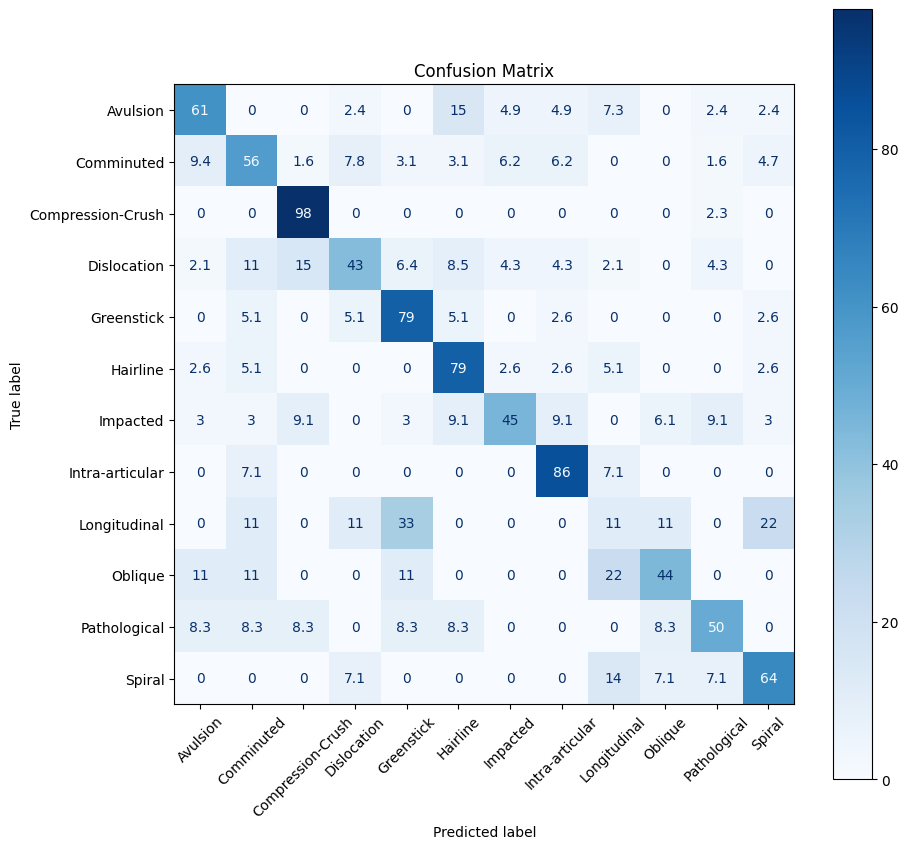

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(model, dataloader, device, class_names, normalize=True):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
        cm = np.nan_to_num(cm)  # handle div by zero
        fmt = ".2f"
        title = "Normalized Confusion Matrix (%)"
        cm = cm * 100
    else:
        fmt = "d"
        title = "Confusion Matrix (Counts)"

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(cmap='Blues', ax=ax, xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()

# class_names = ['class_0', 'class_1', ..., 'class_11']  # replace with your actual labels
class_name = class_columns
plot_confusion_matrix(model, loader_test, device, class_name)

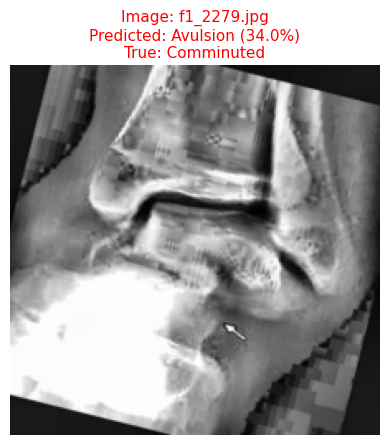

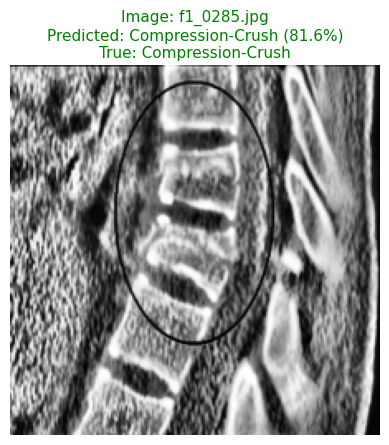

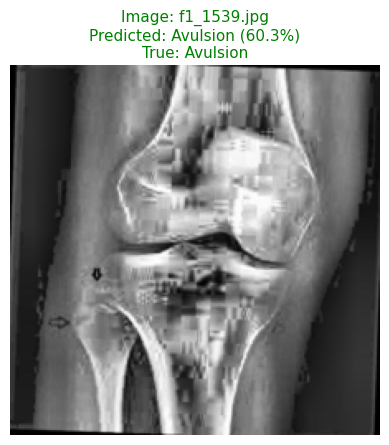

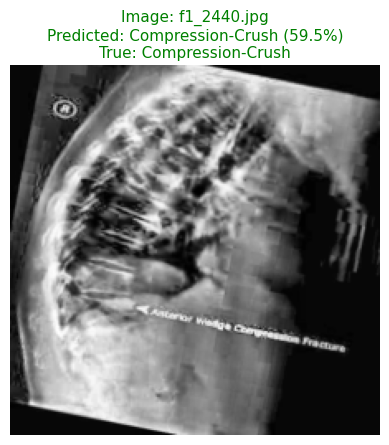

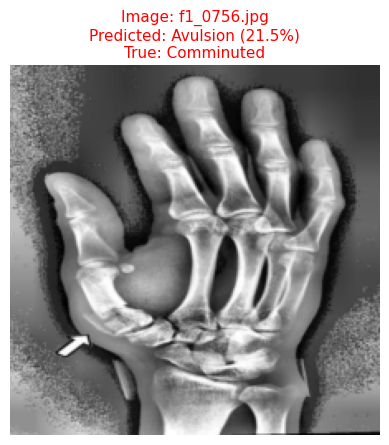

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os

def show_prediction(model, dataloader, device, class_names, num_images=5):
    model.eval()
    images_shown = 0

    with torch.no_grad():
        for batch in dataloader:
            # Handle datasets that return (img, label) or (img, label, path)
            if len(batch) == 2:
                inputs, labels = batch
                paths = [None] * len(labels)
            elif len(batch) == 3:
                inputs, labels, paths = batch
            else:
                raise ValueError("Expected DataLoader to return (x, y) or (x, y, path).")

            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            for i in range(inputs.size(0)):
                img = inputs[i].cpu().permute(1, 2, 0).numpy()
                img = (img - img.min()) / (img.max() - img.min())  # normalize [0,1]
                pred_class = class_names[preds[i]]
                true_class = class_names[labels[i]]
                confidence = probs[i][preds[i]].item() * 100

                # Image name (if available)
                img_name = os.path.basename(paths[i]) if paths[i] is not None else f"Sample {images_shown+1}"

                plt.imshow(img)
                plt.title(
                    f"Image: {img_name}\n"
                    f"Predicted: {pred_class} ({confidence:.1f}%)\n"
                    f"True: {true_class}",
                    color="green" if pred_class == true_class else "red",
                    fontsize=11
                )
                plt.axis("off")
                plt.show()

                images_shown += 1
                if images_shown >= num_images:
                    return

# class_names = loader_train.dataset.classes  # or your label list
# show_prediction(model, loader_valid, device, class_names, num_images=5)


In [33]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os

def show_most_confident_image(model, dataloader, device, class_names):
    model.eval()
    best_conf = -1.0
    best_sample = None
    best_prob_vector = None

    with torch.no_grad():
        for batch in dataloader:
            # Support (img, label) or (img, label, path)
            if len(batch) == 2:
                inputs, labels = batch
                paths = [None] * len(labels)
            elif len(batch) == 3:
                inputs, labels, paths = batch
            else:
                raise ValueError("Expected DataLoader to return (x, y) or (x, y, path).")

            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            confidences, preds = torch.max(probs, dim=1)

            # Find max confidence in this batch
            batch_max_conf, idx = torch.max(confidences, dim=0)
            if batch_max_conf.item() > best_conf:
                best_conf = batch_max_conf.item()
                best_sample = {
                    "image": inputs[idx].cpu(),
                    "true_label": labels[idx].cpu().item(),
                    "pred_label": preds[idx].cpu().item(),
                    "path": paths[idx],
                }
                best_prob_vector = probs[idx].cpu()

    if best_sample is None:
        print("No samples found.")
        return

    # Display the image
    img = best_sample["image"].permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min())
    pred_class = class_names[best_sample["pred_label"]]
    true_class = class_names[best_sample["true_label"]]
    img_name = os.path.basename(best_sample["path"]) if best_sample["path"] else "Unknown"
    confidence = best_conf * 100

    plt.imshow(img)
    plt.title(
        f"Most Confident Prediction\n"
        f"Image: {img_name}\n"
        f"Predicted: {pred_class} ({confidence:.2f}%)\nTrue: {true_class}",
        color="green" if pred_class == true_class else "red",
        fontsize=11,
    )
    plt.axis("off")
    plt.show()

    print(f"\n✅ Highest confidence: {confidence:.2f}%")
    print(f"Predicted class: {pred_class}")
    print(f"True class: {true_class}")
    print(f"Image name: {img_name}")


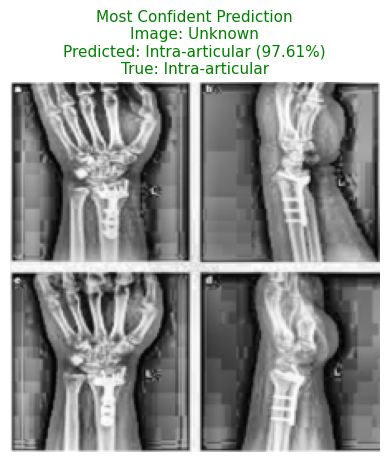


✅ Highest confidence: 97.61%
Predicted class: Intra-articular
True class: Intra-articular
Image name: Unknown


In [34]:
class_names = loader_train.dataset.classes  # or your list
show_most_confident_image(model, loader_train, device, class_names)


# Using attention features of the model DeiT model for localization

In [53]:
# new imports
from PIL import Image
from scipy import ndimage

In [54]:
def extract_timm_attention(model, img_tensor, layers="all"):
    """
    Extracts attention weights from a timm DeiT model using forward hooks.

    Args:
        model (torch.nn.Module): Trained DeiT model from timm.
        img_tensor (torch.Tensor): Preprocessed input image tensor of shape (1, 3, H, W).
        layers (str or list): "all" to extract from all layers, or list of layer indices.

    Returns:
        List[torch.Tensor]: Attention weights from selected transformer layers.
    """
    attention_maps = []

    def hook_fn(module, input, output):
        # 1
        # output shape: (batch_size, num_heads, seq_len, seq_len)
        
        # 2 ---
        # attention_maps.append(output)

        # 3
        B, N, C = input[0].shape  # input[0] is the token sequence
        qkv = module.qkv(input[0])  # (B, N, 3 * embed_dim)
        qkv = qkv.reshape(B, N, 3, module.num_heads, C // module.num_heads)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # (3, B, num_heads, N, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * module.scale  # (B, num_heads, N, N)
        attn = attn.softmax(dim=-1)
        attention_maps.append(attn)


    # Register hooks
    hooks = []
    for i, block in enumerate(model.base.blocks):
        
        if layers == "all" or i in layers:
            
            block.attn.register_forward_hook(hook_fn)
            # hooks.append(h)
            # print(hooks)

    # Run inference
    model.eval()
    with torch.no_grad():
        _ = model(img_tensor.to(device))

    # Remove hooks
    for h in hooks:
        h.remove()

    return attention_maps

In [55]:
# extracting attention weights from image

model_attention = model

image_name = combined_path / 'f1_0285.jpg'
image = Image.open(image_name).convert("RGB")

transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
img_tensor = transform(image).unsqueeze(0)


attentions = extract_timm_attention(model_attention, img_tensor)

In [56]:
def get_att_layer_grid(layer_no, attentions):

    # get attention from layer [0]
    attn = attentions[layer_no]  
    # print(attn.shape)

    # Extract CLS-to-patch attention
    cls_attn = attn[0, :, 0, 1:]  # shape: (num_heads, 196)
    # print(cls_attn.shape)

    # avg across heads
    cls_attn_avg = cls_attn.mean(dim=0)  # shape: (batch_size, num_patches)
    # print(cls_attn_avg.shape)

    #reshape
    grid_size = 14
    attn_grid = cls_attn_avg.reshape(grid_size, grid_size)
    # print(attn_grid.shape)

    return cls_attn_avg, attn_grid

In [50]:
# ----------------  Threshold the Attention Grid

# Convert to NumPy
attn_np = attn_grid.detach().cpu().numpy()

# Flatten and sort attention values
flat = attn_np.flatten()
sorted_vals = np.sort(flat)

# Create a binary mask of high-attention areas
k = int(0.8 * len(sorted_vals))
threshold = sorted_vals[k]
mask = attn_np > threshold


# get row and columns of max value
top_index = cls_attn_avg.argmax().item()
grid_size = 14
row = top_index // grid_size
col = top_index % grid_size
patch_size = 224 // grid_size


NameError: name 'attn_grid' is not defined

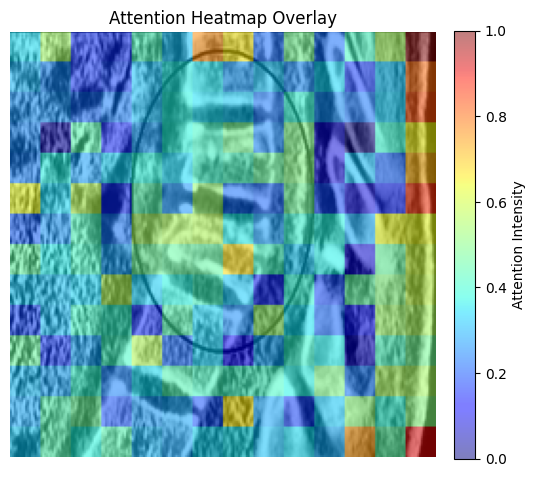

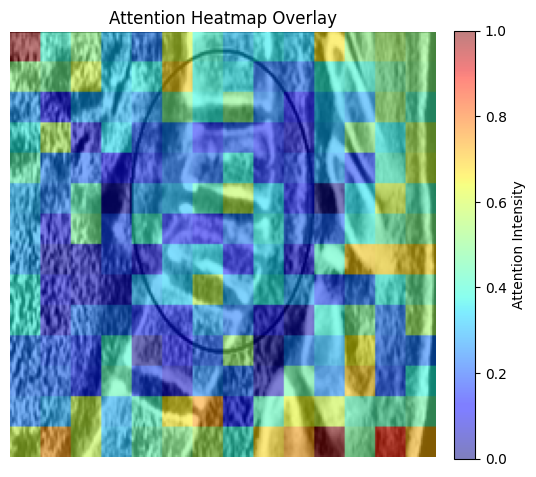

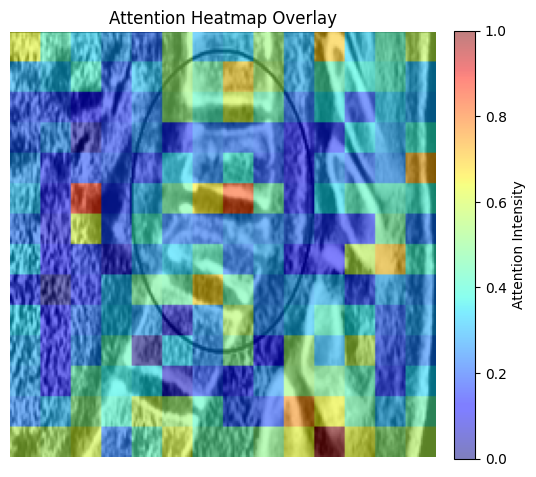

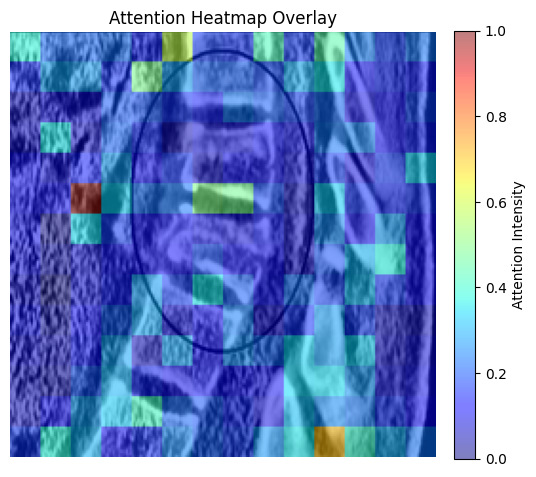

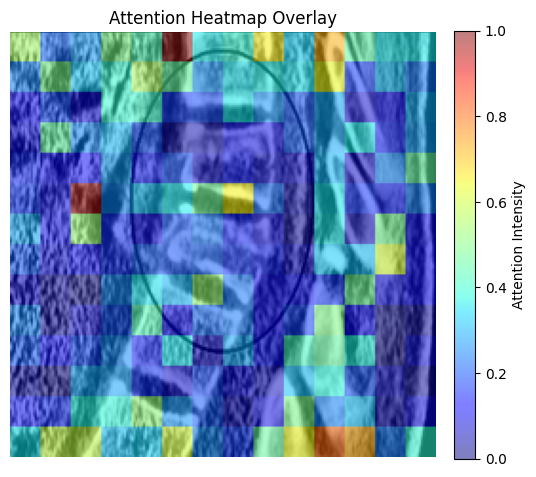

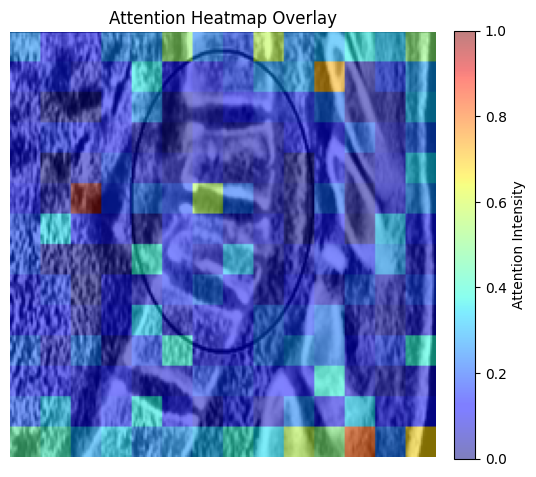

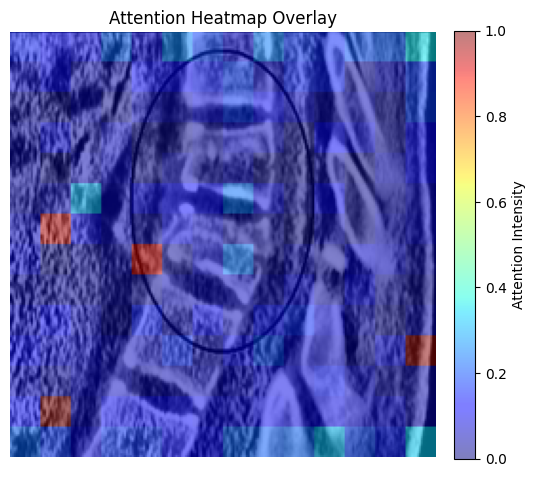

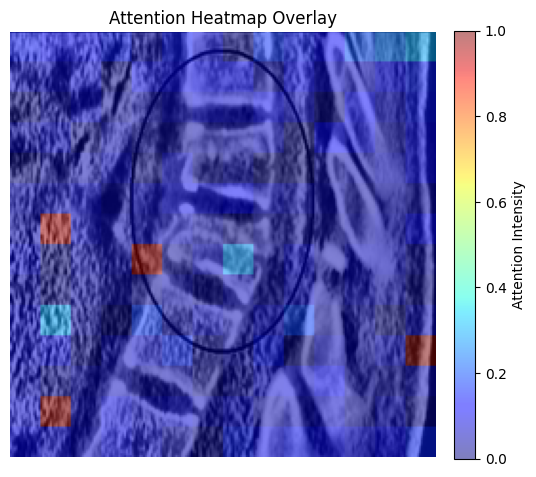

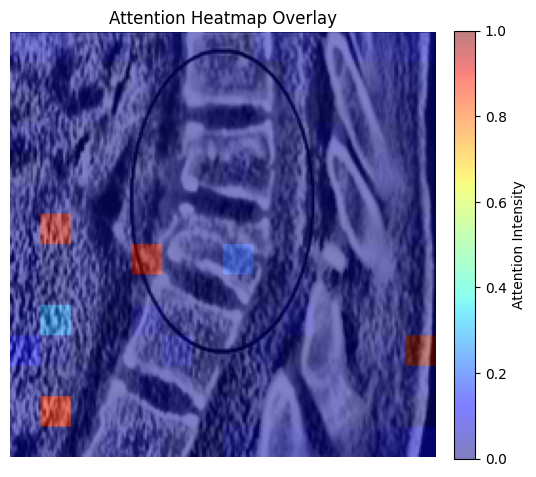

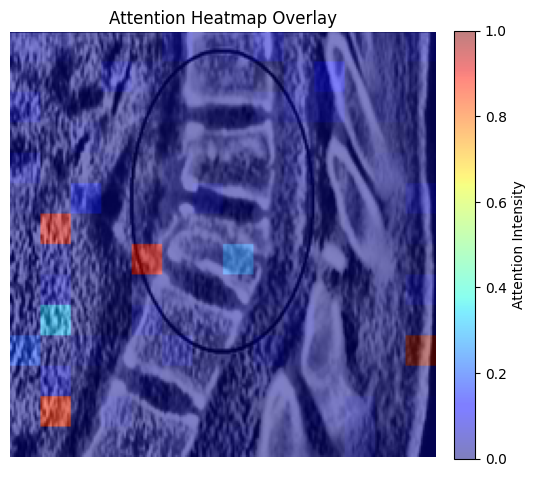

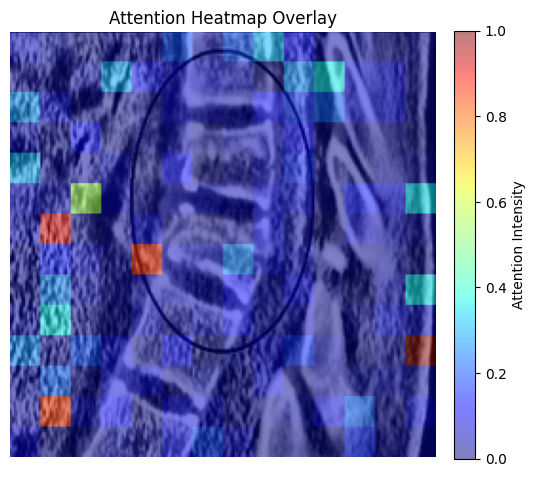

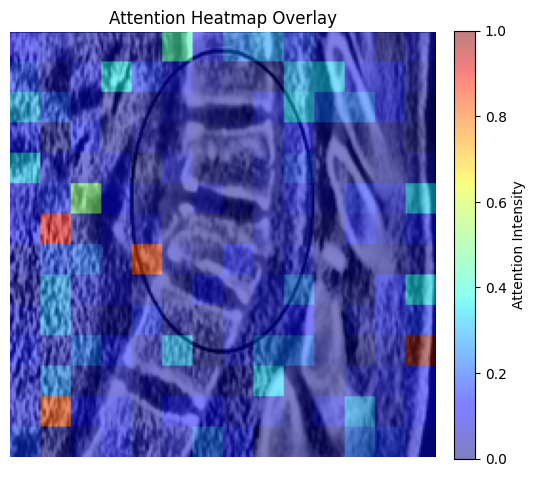

In [57]:
# ----------------  Heatmap on top of image

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


def make_heatmap(image_name, cls_attn_avg):
    # Load and resize image to 224x224
    image = Image.open(image_name).convert("RGB").resize((224, 224))

    # Convert to NumPy array
    img_np = np.array(image)

    # Normalize attention grid to [0, 1]
    attn_map = cls_attn_avg.reshape(14, 14).detach().cpu().numpy()
    attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min())

    # Upsample attention map to image size
    attn_map = np.kron(attn_map, np.ones((16, 16)))  # 14x14 → 224x224

    plt.figure(figsize=(6, 6))
    plt.imshow(img_np)
    heatmap = plt.imshow(attn_map, cmap='jet', alpha=0.5)  # alpha controls transparency
    plt.colorbar(heatmap, fraction=0.046, pad=0.04, label="Attention Intensity")
    plt.axis('off')
    plt.title("Attention Heatmap Overlay")
    plt.show()


for layer in range(len(attentions)):
    cls_attn_avg, attn_grid = get_att_layer_grid(layer, attentions)

    make_heatmap(image_name, cls_attn_avg)


